In [1]:
# Libraries
import os
import time
import shutil
import pathlib
import itertools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")



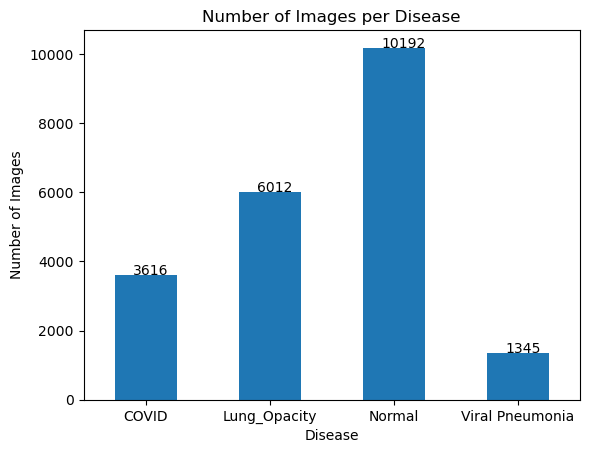

Training data size = 16932, Validation data size = 2116, Testing data size = 2117


In [2]:
# Set the directory containing the image files
data_dir = 'COVID-19_Radiography_Dataset'

# Lists to store filepaths and their labels
filepaths = []
labels = []

# Get all the files present in all 4 folders in the dataset directory and map them to a class name based on what folder it is present
for fold in os.listdir(data_dir):
    foldpath = os.path.join(data_dir, fold)

    if pathlib.Path(foldpath).suffix != '':
        continue
    if os.path.isdir(foldpath):
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            if os.path.isdir(fpath):
                if pathlib.Path(foldpath).suffix == '':
                    # We will not be using Mask Images so ignoring the mask folders
                    if pathlib.Path(fpath).parts[-1] == 'masks' or pathlib.Path(fpath).parts[-1] == 'Masks' or pathlib.Path(fpath).parts[-1] == 'MASKS':
                        continue
                    else:
                        o_file = os.listdir(fpath)
                        for f in o_file:
                            ipath = os.path.join(fpath, f)
                            filepaths.append(ipath)
                            labels.append(fold)
                else:
                    filepaths.append(fpath)
                    labels.append(fold)

# Storing File names and corresponding class in a dataframe
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})


# show the plot to visualize number of images per class
label_counts = df.groupby('labels')['filepaths'].count()
ax = label_counts.plot(kind='bar')

plt.xlabel('Disease')
plt.ylabel('Number of Images')
plt.title('Number of Images per Disease')
plt.xticks(rotation=0)

for i in ax.patches:
    ax.text(i.get_x()+.15, i.get_height()+.5, str(i.get_height()), fontsize=10)
plt.show()

# Split the Data into training, validation, and test sets at a ratio of 80-10-10
strat = df['labels']
train_df, semi_split_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
strat = semi_split_df['labels']
valid_df, test_df = train_test_split(semi_split_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)


print(f'Training data size = {len(train_df)}, Validation data size = {len(valid_df)}, Testing data size = {len(test_df)}')


In [3]:
# Calculate the length of the test dataset
test_length = len(test_df)

# Find all factors of the test dataset length less than or equal to 80
factors = []
for n in range(1, test_length+1):
    if test_length % n == 0 and test_length/n <= 80:
        factors.append(n)

# the test batch size is the largest of the factors
test_batch_size = max(sorted(factors, reverse=True))

# Calculate the number of steps per epoch for the test dataset
test_steps = test_length // test_batch_size

# Define a function that returns the input image unchanged
def scalar(img):
    return img

# Set up image data generators for the training, validation, and test datasets
aug_train = ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True)
aug_test = ImageDataGenerator(preprocessing_function=scalar)

train_gen = aug_train.flow_from_dataframe(
    train_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=16
)

valid_gen = aug_test.flow_from_dataframe(
    valid_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True,
    batch_size=16
)

test_gen = aug_test.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=(224, 224),
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)


Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


In [4]:
train_data = train_gen.class_indices
classes = list(train_data.keys())
images, labels = next(train_gen)
batch_size = len(labels)        # length of batch size

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get class names and number of classes
class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)

# Create a dictionary to store images for each class
class_images = {class_name: [] for class_name in class_names}

# Loop over the samples until 5 images per class are found
while True:
    images, labels = next(train_gen)
    for j in range(len(labels)):
        class_name = class_names[np.argmax(labels[j])]
        if len(class_images[class_name]) < 5:
            class_images[class_name].append(images[j])

    # Stop once 5 images per class are found
    if all(len(images) == 5 for images in class_images.values()):
        break

# Create a figure with 5 rows and N columns
fig, axs = plt.subplots(5, num_classes, figsize=(20, 20))

# Loop over the classes and plot the corresponding images
for i in range(num_classes):
    for j in range(5):
        axs[j, i].imshow(class_images[class_names[i]][j]/255)
        axs[j, i].set_title(class_names[i])
        axs[j, i].axis('off')

plt.show()


In [7]:
# Set the batch size, image size, and number of classes
batch_size = 16
img_height, img_width = 224, 224
num_classes = len(train_gen.class_indices)


# Create ResNet101 model with pre-trained weights
resnet = ResNet101(include_top=False, weights='imagenet', input_shape=(img_height, img_width, 3))

# Add new fully connected layers
x = resnet.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define the final model
model = Model(inputs=resnet.input, outputs=predictions)

# Freeze pre-trained layers
for layer in resnet.layers:
    layer.trainable = False

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [8]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block8_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block7_out[0][0]']       
                                                                                                  
 conv4_block8_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block8_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block8_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block8_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block8_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block8_1_relu[0][0]']    
          

                                )                                                                 
                                                                                                  
 conv4_block11_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block10_out[0][0]']      
                                                                                                  
 conv4_block11_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block11_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_blo

 conv4_block13_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block13_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block14_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block13_out[0][0]']      
                                                                                                  
 conv4_block14_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block14_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block14_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block14_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv4_block16_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block16_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block17_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block16_out[0][0]']      
                                                                                                  
 conv4_block17_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block17_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block17_1_relu (Activati  (None, 14, 14, 256)  0          ['conv4_block17_1_bn[0][0]']     
 on)      

                                )                                 'conv4_block19_3_bn[0][0]']     
                                                                                                  
 conv4_block19_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block19_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block19_out[0][0]']      
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_blo

 conv4_block22_add (Add)        (None, 14, 14, 1024  0           ['conv4_block21_out[0][0]',      
                                )                                 'conv4_block22_3_bn[0][0]']     
                                                                                                  
 conv4_block22_out (Activation)  (None, 14, 14, 1024  0          ['conv4_block22_add[0][0]']      
                                )                                                                 
                                                                                                  
 conv4_block23_1_conv (Conv2D)  (None, 14, 14, 256)  262400      ['conv4_block22_out[0][0]']      
                                                                                                  
 conv4_block23_1_bn (BatchNorma  (None, 14, 14, 256)  1024       ['conv4_block23_1_conv[0][0]']   
 lization)                                                                                        
          

 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block2_out[0][0]']       
                                                                                                  
 conv5_blo

In [10]:
# Train the model
history = model.fit(
    train_gen,
    epochs=20,
    callbacks = early_stop,
    validation_data=valid_gen,)

Epoch 1/20


2023-04-19 18:25:25.959682: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-19 18:25:27.967254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1059/1059 [==============================] - ETA: 0s - loss: 1.5927 - accuracy: 0.8511

2023-04-19 18:28:00.198339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1059/1059 [==============================] - 174s 161ms/step - loss: 1.5927 - accuracy: 0.8511 - val_loss: 0.3248 - val_accuracy: 0.8847
Epoch 2/20
1059/1059 [==============================] - 168s 159ms/step - loss: 0.2602 - accuracy: 0.9083 - val_loss: 0.2970 - val_accuracy: 0.9022
Epoch 3/20
1059/1059 [==============================] - 168s 158ms/step - loss: 0.2129 - accuracy: 0.9253 - val_loss: 0.3057 - val_accuracy: 0.8984
Epoch 4/20
1059/1059 [==============================] - 168s 158ms/step - loss: 0.1778 - accuracy: 0.9380 - val_loss: 0.2973 - val_accuracy: 0.9045
Epoch 5/20
1059/1059 [==============================] - 168s 158ms/step - loss: 0.1588 - accuracy: 0.9444 - val_loss: 0.3747 - val_accuracy: 0.8837
Epoch 6/20
1059/1059 [==============================] - 168s 158ms/step - loss: 0.1466 - accuracy: 0.9499 - val_loss: 0.3275 - val_accuracy: 0.8989
Epoch 7/20
1059/1059 [==============================] - 168s 159ms/step - loss: 0.1266 - accuracy: 0.9577 - val_loss: 0.294

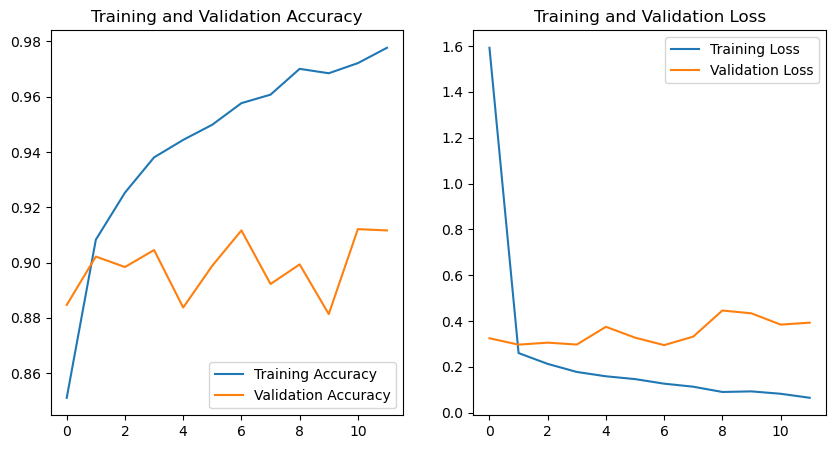

In [11]:
# Plot the training and validation accuracy over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc)) #Change with the number of epochs

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [12]:
model.save('ResNet_Saved.h5')